In [1]:
# install spotipy to be used in getting artist data
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.0 MB/s eta 0:00:00


# Set up and initialization ⚙

In [2]:
# Import the libraries / anzisha maktaba
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from google.colab import userdata
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
from sklearn.cluster import KMeans

# Making the Spotify client

In [3]:
# get the spotify api Key
secret = userdata.get('spotify')
sp_cid = userdata.get('Spotify_cid')

# Create the credentials manager
client_credentials_manager = SpotifyClientCredentials(
    client_id=sp_cid,
    client_secret=secret
)

# Set up the Spotipy client
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# **Getting artist info**

In [4]:
# Function to get artist details and top tracks
def get_artist_data(artist_uri):
    # Extract artist ID from URI
    artist_id = artist_uri.split(":")[2]

    # Get artist details
    artist = sp.artist(artist_id)
    artist_name = artist['name']
    artist_popularity = artist['popularity']
    artist_genres = artist['genres']
    artist_followers = artist['followers']['total']
    artist_url = artist['external_urls']['spotify']

    # Print artist basic info
    print(f"Artist: {artist_name}")
    print(f"Popularity: {artist_popularity}")
    print(f"Genres: {', '.join(artist_genres)}")
    print(f"Followers: {artist_followers}")
    print(f"Spotify URL: {artist_url}")

    # Get artist's top 5 tracks
    top_tracks = sp.artist_top_tracks(artist_id, country='Kenya')['tracks']

    # Create an empty list to store track data
    track_data = []

    for track in top_tracks:
        track_name = track['name']
        track_popularity = track['popularity']
        track_duration = track['duration_ms'] / 1000  # Convert ms to seconds
        track_explicit = track['explicit']

        # Get audio features for the track
        track_id = track['id']
        audio_features = sp.audio_features(track_id)[0]
        danceability = audio_features['danceability']
        energy = audio_features['energy']
        loudness = audio_features['loudness']
        tempo = audio_features['tempo']
        valence = audio_features['valence']

        # Append track data to the list
        track_data.append({
            'Track Name': track_name,
            'Popularity': track_popularity,
            'Duration (seconds)': track_duration,
            'Explicit': track_explicit,
            'Danceability': danceability,
            'Energy': energy,
            'Loudness (dB)': loudness,
            'Tempo (BPM)': tempo,
            'Valence': valence
        })

    # Convert the track data to a DataFrame
    df_tracks = pd.DataFrame(track_data)

    return df_tracks

# Example: Get data for a specific artist using their URI
artist_uri = 'spotify:artist:3cAisWS37sGCCtRgWfvrod'  # Replace with the actual URI of the artist
df_artist_data = get_artist_data(artist_uri)

# Display the DataFrame
print(df_artist_data.head())  # Shows the first few rows of the DataFrame

Artist: Diamond Platnumz
Popularity: 60
Genres: azontobeats, bongo flava, tanzanian pop
Followers: 1263425
Spotify URL: https://open.spotify.com/artist/3cAisWS37sGCCtRgWfvrod
                                          Track Name  Popularity  \
0                           Komasava (Comment Ça Va)          58   
1                                 Shu! (feat. Chley)          54   
2                                         OLOLUFE MI          51   
3  Komasava (Comment Ça Va) [feat. Khalil Harriso...          50   
4                                              Enjoy          50   

   Duration (seconds)  Explicit  Danceability  Energy  Loudness (dB)  \
0             276.106     False         0.863   0.837         -6.374   
1             263.571     False         0.878   0.890         -4.967   
2             235.042     False         0.859   0.778         -5.883   
3             285.663     False         0.857   0.799         -6.339   
4             216.724     False         0.892   0.673   

# **Track Analysis**

In [5]:
df_artist_data.describe()

,Popularity,Duration (seconds),Danceability,Energy,Loudness (dB),Tempo (BPM),Valence
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.00000
mean,49.500000,236.078100,0.78840,0.801300,-4.993500,119.888100,0.76710
std,4.034573,31.635767,0.11311,0.066943,1.057973,33.921269,0.13586
min,45.000000,193.190000,0.51600,0.673000,-6.374000,90.000000,0.48400
25%,47.000000,211.681000,0.75125,0.778500,-5.802750,104.495750,0.71375
50%,48.500000,231.532000,0.82300,0.789500,-4.881000,112.994000,0.77900
75%,50.750000,259.928000,0.86200,0.836500,-4.482250,117.473750,0.86850
max,58.000000,285.663000,0.89200,0.896000,-3.258000,211.523000,0.92900


In [6]:
df_artist_data.head()

,Track Name,Popularity,Duration (seconds),Explicit,Danceability,Energy,Loudness (dB),Tempo (BPM),Valence
0,Komasava (Comment Ça Va),58,276.106,False,0.863,0.837,-6.374,112.998,0.764
1,Shu! (feat. Chley),54,263.571,False,0.878,0.890,-4.967,112.016,0.722
2,OLOLUFE MI,51,235.042,False,0.859,0.778,-5.883,117.978,0.929
3,Komasava (Comment Ça Va) [feat. Khalil Harriso...,50,285.663,False,0.857,0.799,-6.339,112.990,0.711
4,Enjoy,50,216.724,False,0.892,0.673,-4.669,115.961,0.807


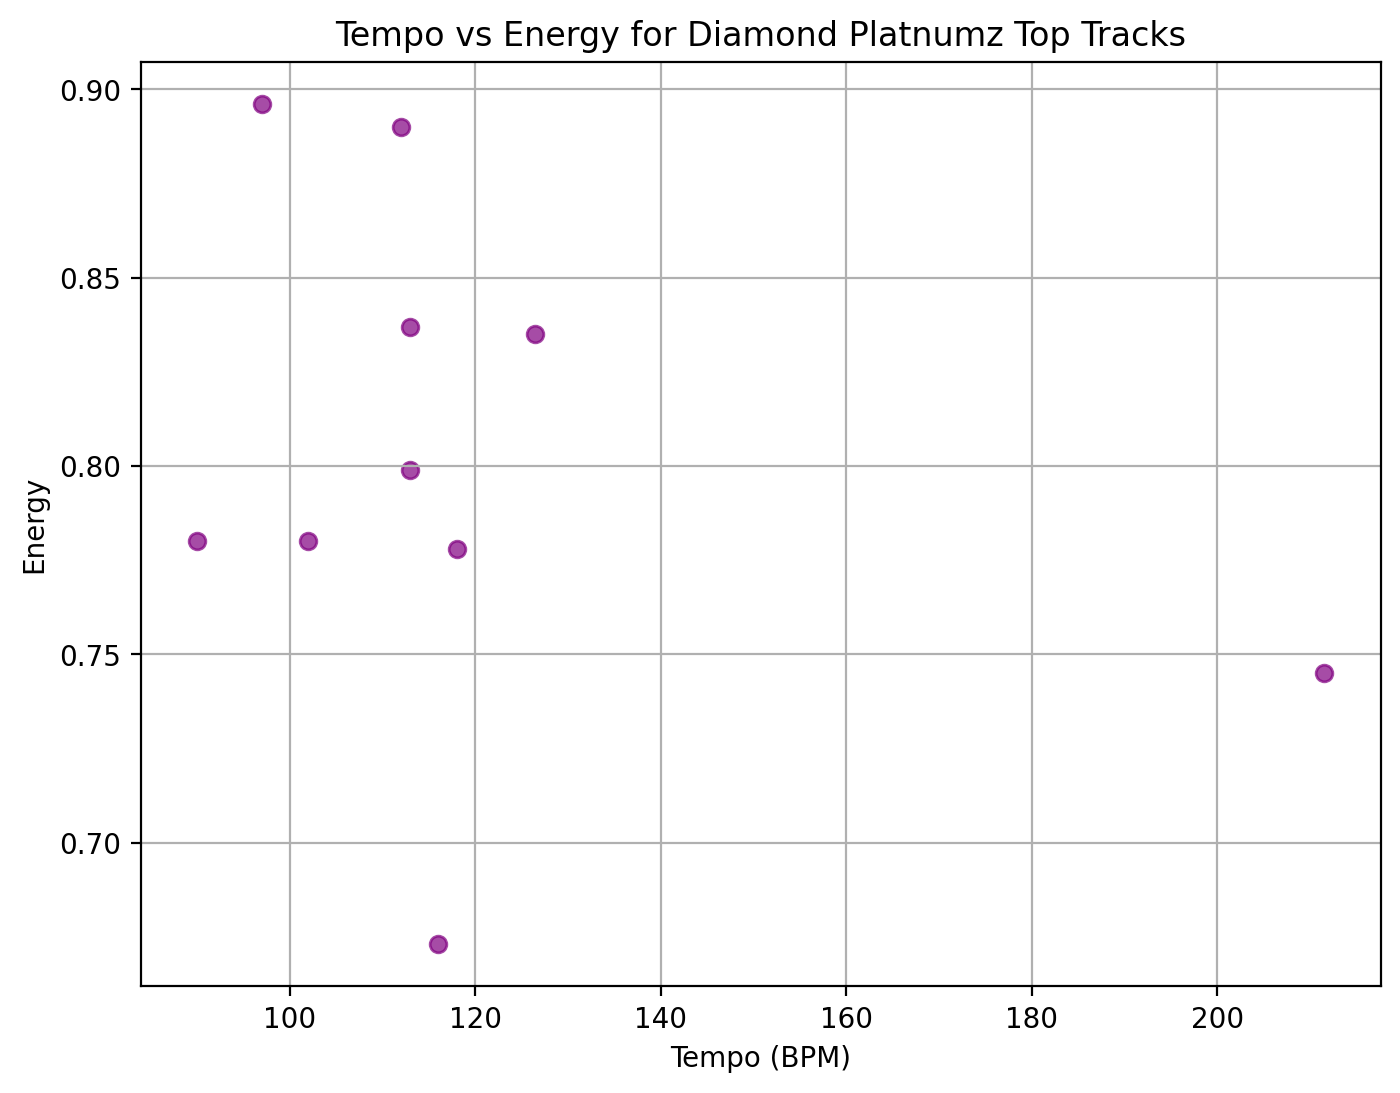

In [7]:
# Scatter plot for Tempo vs Energy
plt.figure(figsize=(8, 6))
plt.scatter(df_artist_data['Tempo (BPM)'], df_artist_data['Energy'], color='purple', alpha=0.7)
plt.title('Tempo vs Energy for Diamond Platnumz Top Tracks')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Energy')
plt.grid(True)
plt.show()


**Overview**

This scatter plot examines the relationship between the tempo (BPM) and energy of Diamond Platnumz's top tracks. Tempo measures the speed of a track, while energy quantifies its intensity and excitement level.

**Key Observations**

**Clustering:**

The data points cluster in a few distinct regions, suggesting that Diamond Platnumz's top tracks tend to fall within certain tempo and energy ranges.

* **Moderate Tempo and High Energy:** A cluster of points is observed in the mid-tempo range (around 100-120 BPM) with relatively high energy levels. This suggests that Diamond Platnumz often uses moderate tempos to create energetic and upbeat tracks.

* **Lower Tempo and Energy:** There's a smaller cluster of points with lower tempo and energy levels, indicating that some of his top tracks have a slower, more relaxed vibe.

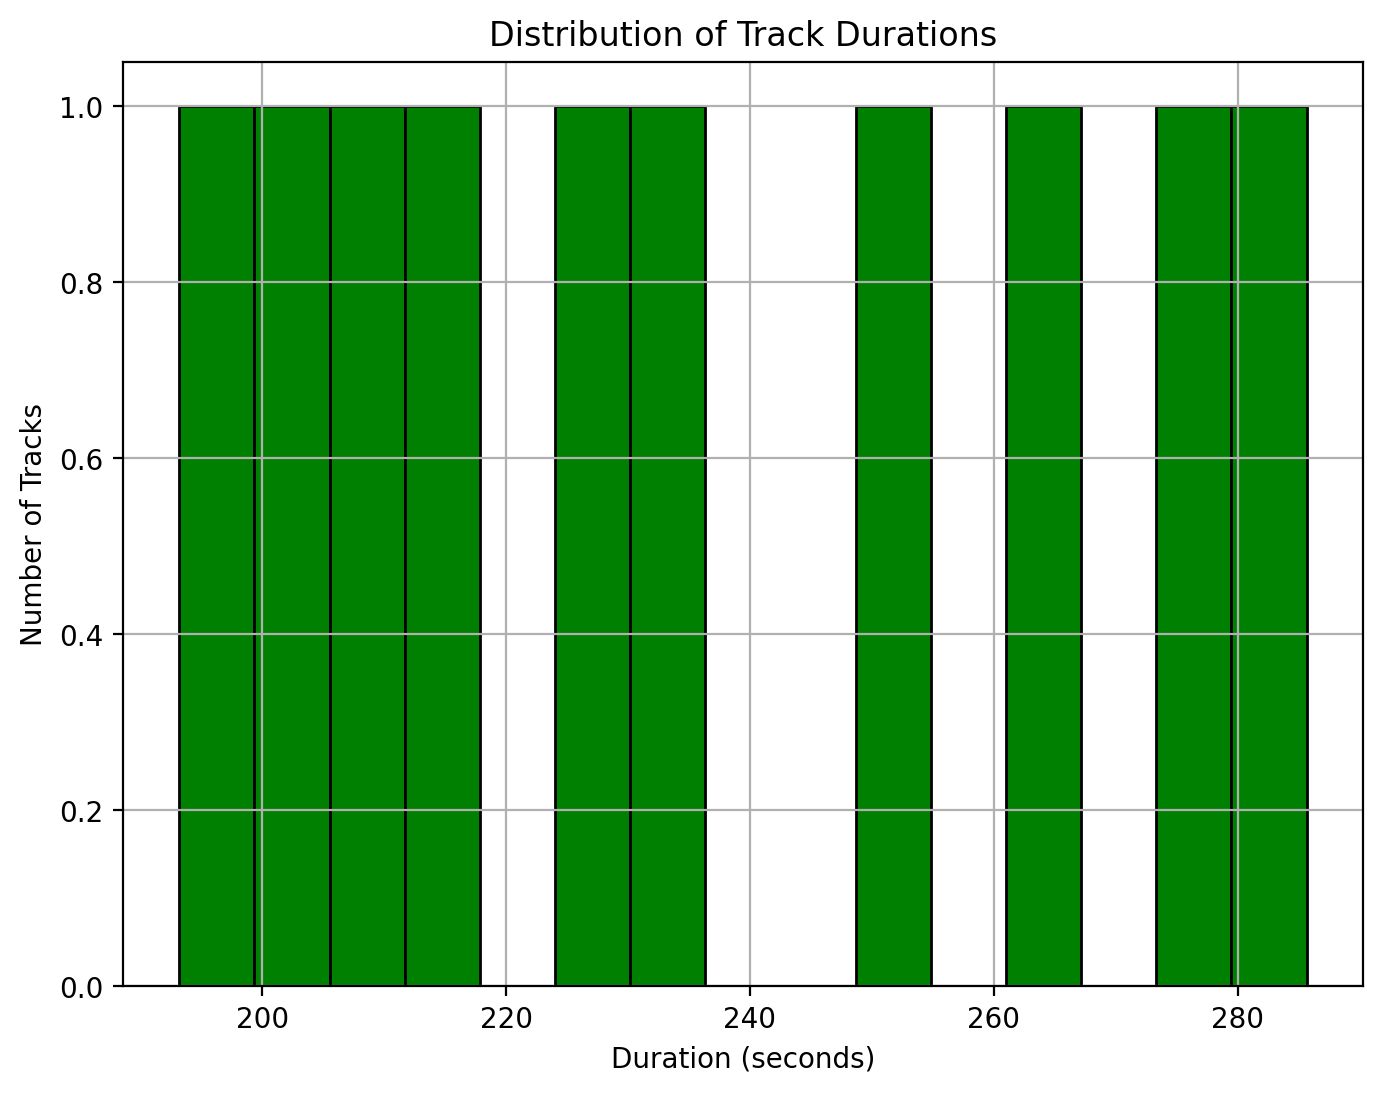

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(df_artist_data['Duration (seconds)'], bins=15, color='green', edgecolor='black')
plt.title('Distribution of Track Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Tracks')
plt.grid(True)
plt.show()


**Overview**

This histogram visualizes the distribution of track durations in seconds. It provides insights into the typical length of tracks within the artist's dataset.

**Key Observations:**

* **Discrete Distribution:** The histogram shows a discrete distribution, with distinct bars representing specific duration ranges.

* **Uniform Distribution:** The bars are of approximately equal height, suggesting a relatively uniform distribution of track durations.

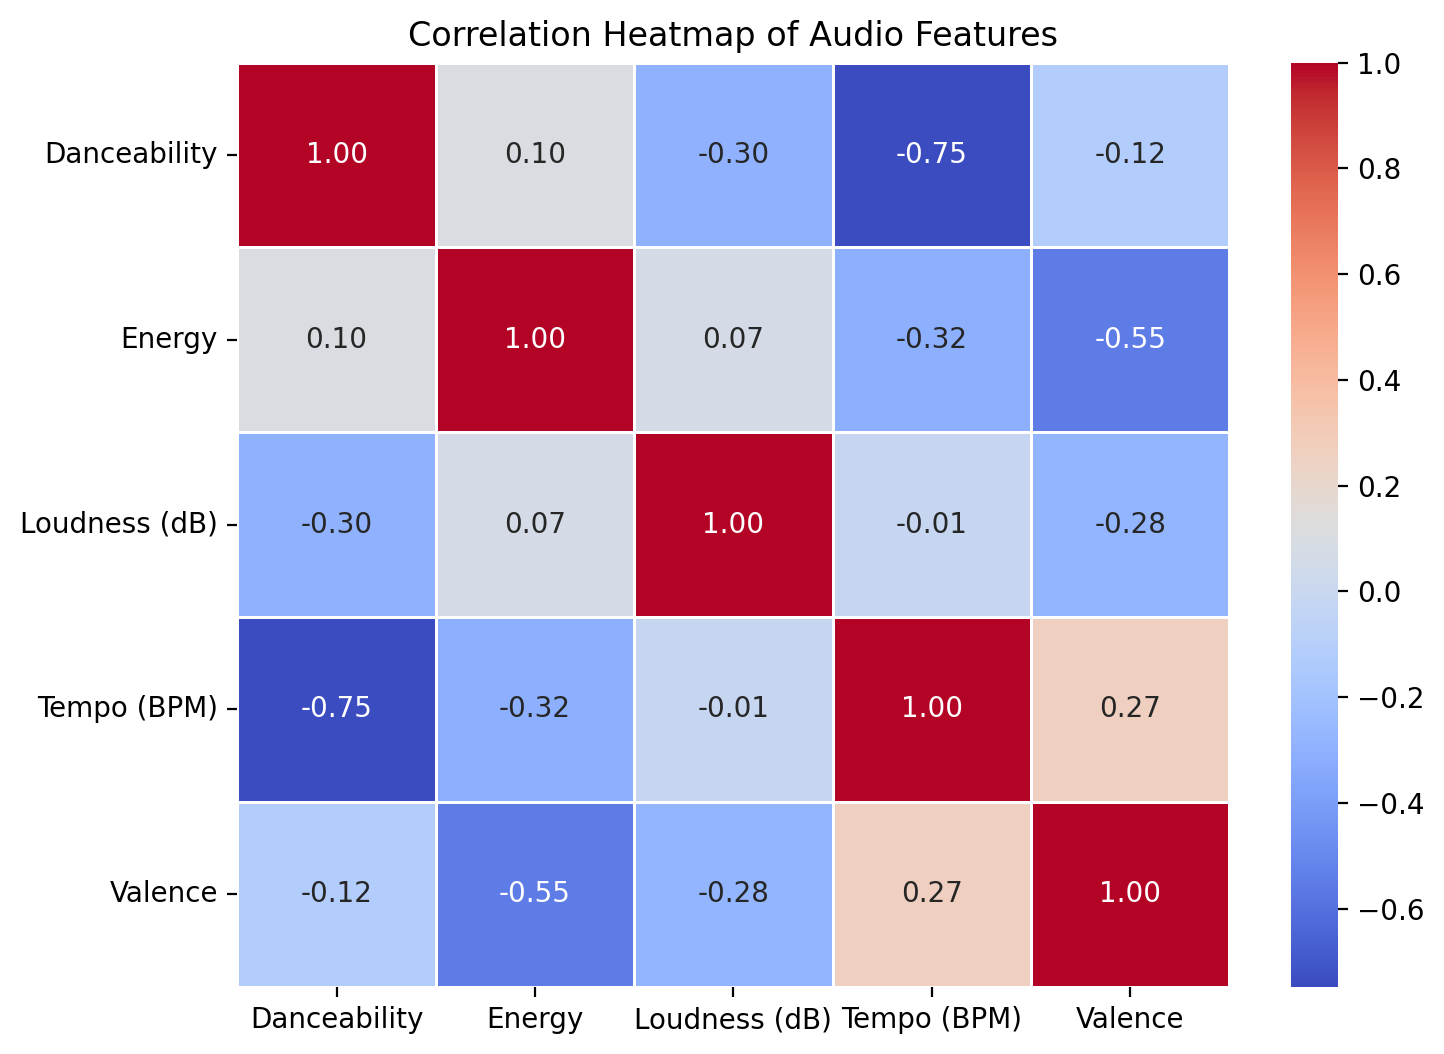

In [9]:
# Calculate correlations between audio features
correlation_matrix = df_artist_data[['Danceability', 'Energy', 'Loudness (dB)', 'Tempo (BPM)', 'Valence']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Audio Features')
plt.show()


**Overview**

This correlation heatmap visualizes the relationships between various audio features, including Danceability, Energy, Loudness (dB), Tempo (BPM), and Valence. A correlation coefficient, ranging from -1 to 1, measures the strength and direction of the linear relationship between two variables.

**Key Observations**

* **Strong Negative Correlation between Danceability and Tempo**:The heatmap reveals a strong negative correlation between Danceability and Tempo. This indicates that as the tempo of a track increases, its danceability tends to decrease. This is likely due to the fact that faster-paced music may not be as suitable for dancing.

* **Moderate Negative Correlation between Energy and Valence:** There's a moderate negative correlation between Energy and Valence. This suggests that energetic tracks tend to have a more negative or neutral mood, while less energetic tracks often have a more positive mood.

* **Weak Correlations:** Most of the other correlations are weak or negligible, indicating that these features are not strongly related to each other.

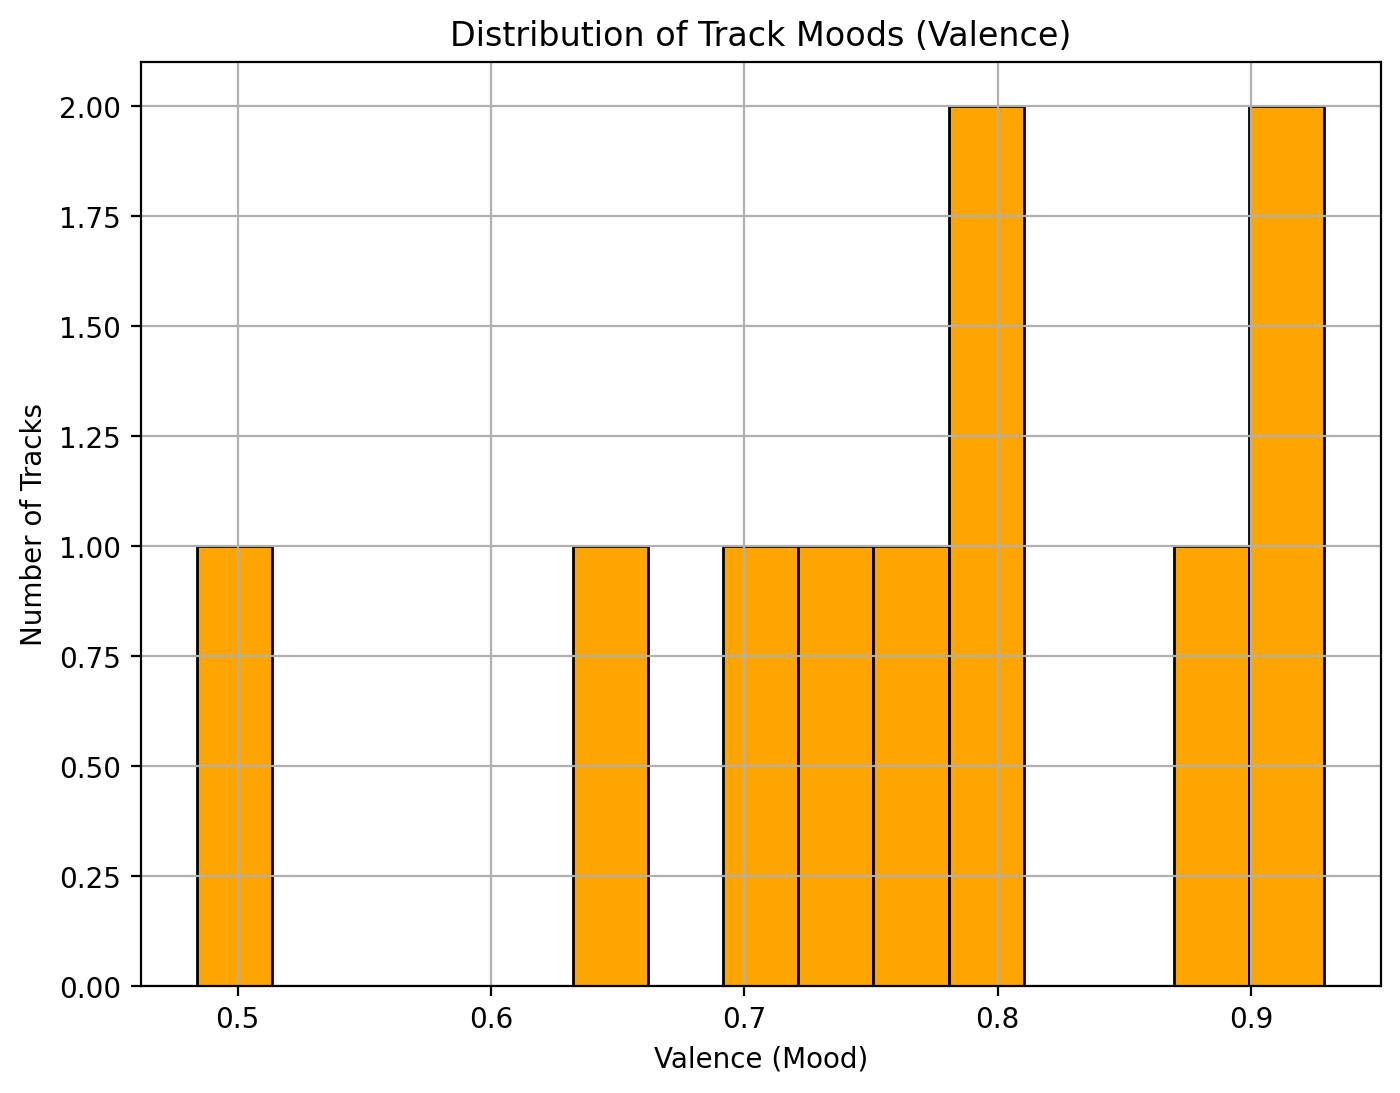

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(df_artist_data['Valence'], bins=15, color='orange', edgecolor='black')
plt.title('Distribution of Track Moods (Valence)')
plt.xlabel('Valence (Mood)')
plt.ylabel('Number of Tracks')
plt.grid(True)
plt.show()


**Overview:**

This histogram visualizes the distribution of track moods, measured by valence. Valence is a musical feature that quantifies the positivity or negativity of a track's mood. A higher valence indicates a more positive mood, while a lower valence indicates a more negative mood.

**Key Observations:**


* **Multiple Peaks:** The histogram shows multiple peaks, indicating that the tracks in the dataset are distributed across several distinct mood ranges.

* **Positive Skew:** The distribution is slightly skewed to the right, suggesting that there are more tracks with higher valence values (more positive moods) compared to lower valence values.

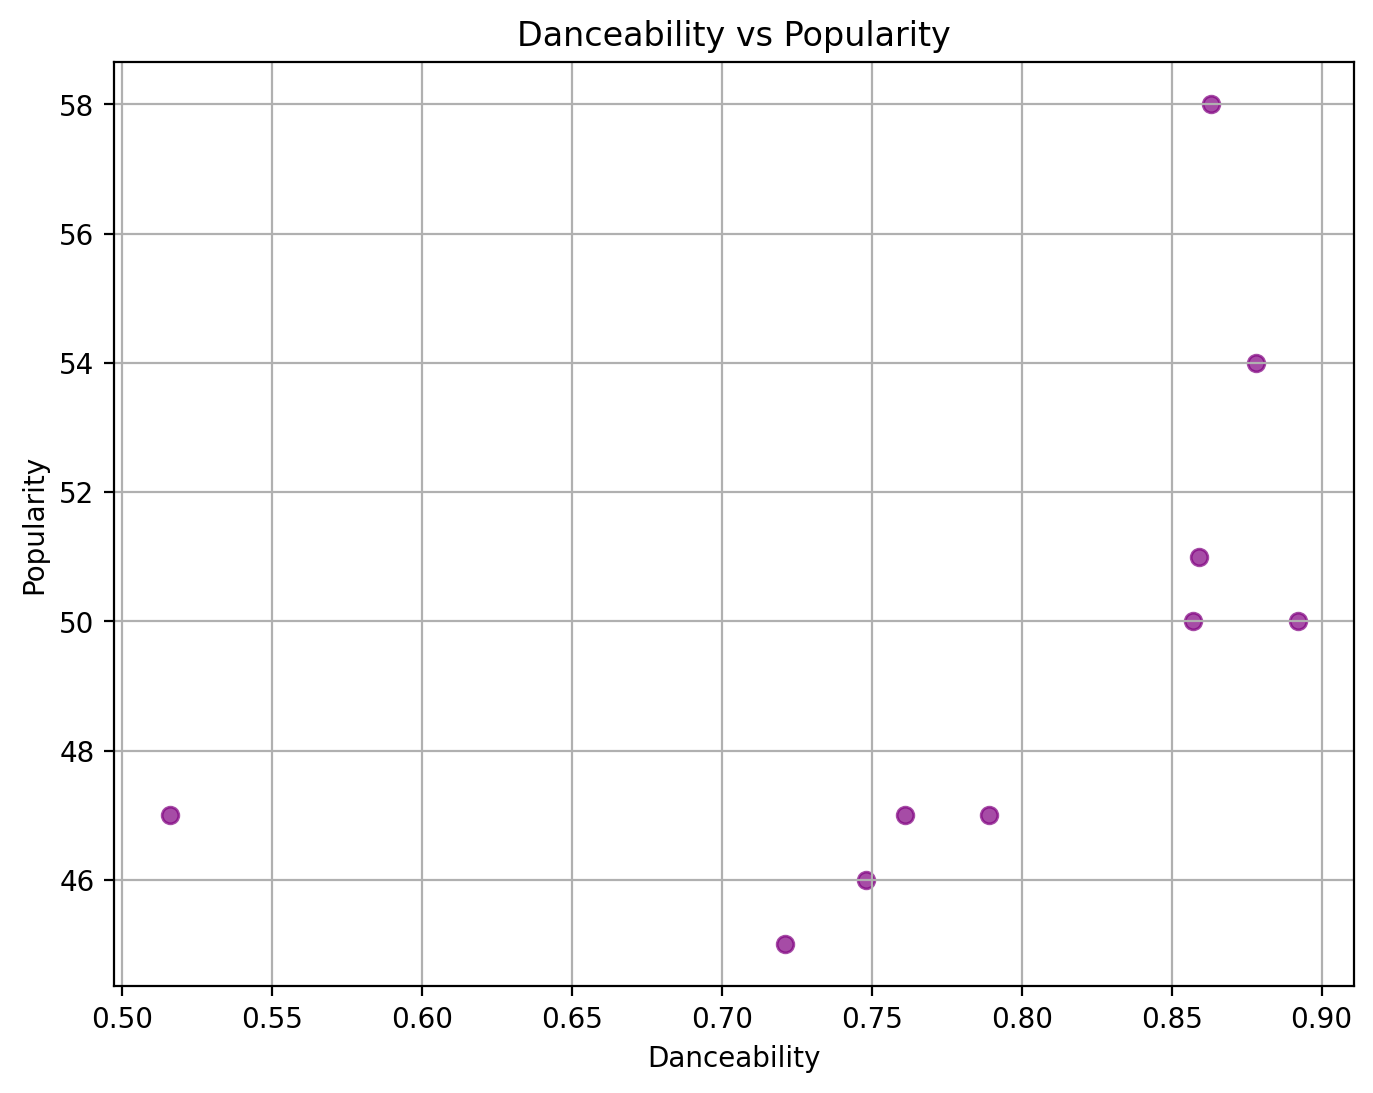

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(df_artist_data['Danceability'], df_artist_data['Popularity'], color='purple', alpha=0.7)
plt.title('Danceability vs Popularity')
plt.xlabel('Danceability')
plt.ylabel('Popularity')
plt.grid(True)
plt.show()


**Overview**

This scatter plot examines the relationship between the danceability and popularity of a set of tracks. Danceability measures how suitable a track is for dancing, while popularity reflects the track's overall popularity.

**Key Observations**

* **Positive Correlation:** There appears to be a weak positive correlation between danceability and popularity. As the danceability of a track increases, its popularity tends to increase as well, although the relationship is not very strong.


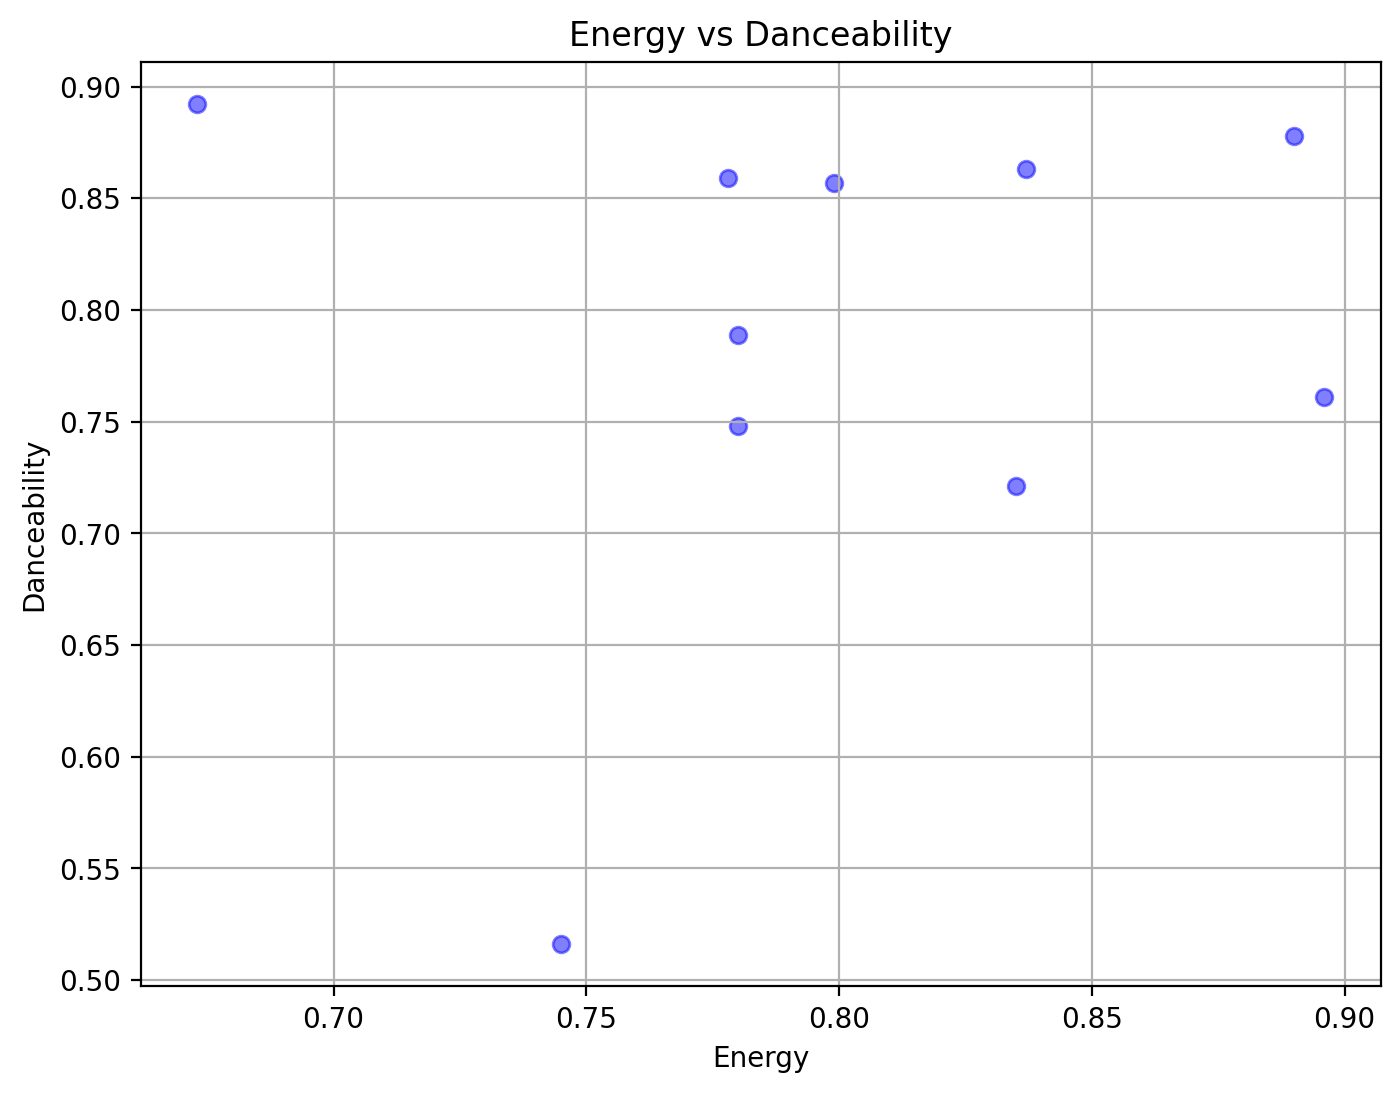

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(df_artist_data['Energy'], df_artist_data['Danceability'], color='blue', alpha=0.5)
plt.title('Energy vs Danceability')
plt.xlabel('Energy')
plt.ylabel('Danceability')
plt.grid(True)
plt.show()


**Overview:**

This scatter plot examines the relationship between the energy and danceability of a set of tracks. Energy and danceability are musical features that quantify the intensity and rhythmic suitability of a track for dancing, respectively.

**Key Observations:**

* **Positive Correlation:** There appears to be a positive correlation between energy and danceability. As the energy of a track increases, its danceability tends to increase as well. This suggests that energetic tracks are generally more suitable for dancing.

* **Clustering:** The data points tend to cluster in certain regions of the plot. There's a cluster of points in the upper right corner, indicating tracks with high energy and high danceability. Another cluster is visible in the lower left corner, representing tracks with lower energy and lower danceability.

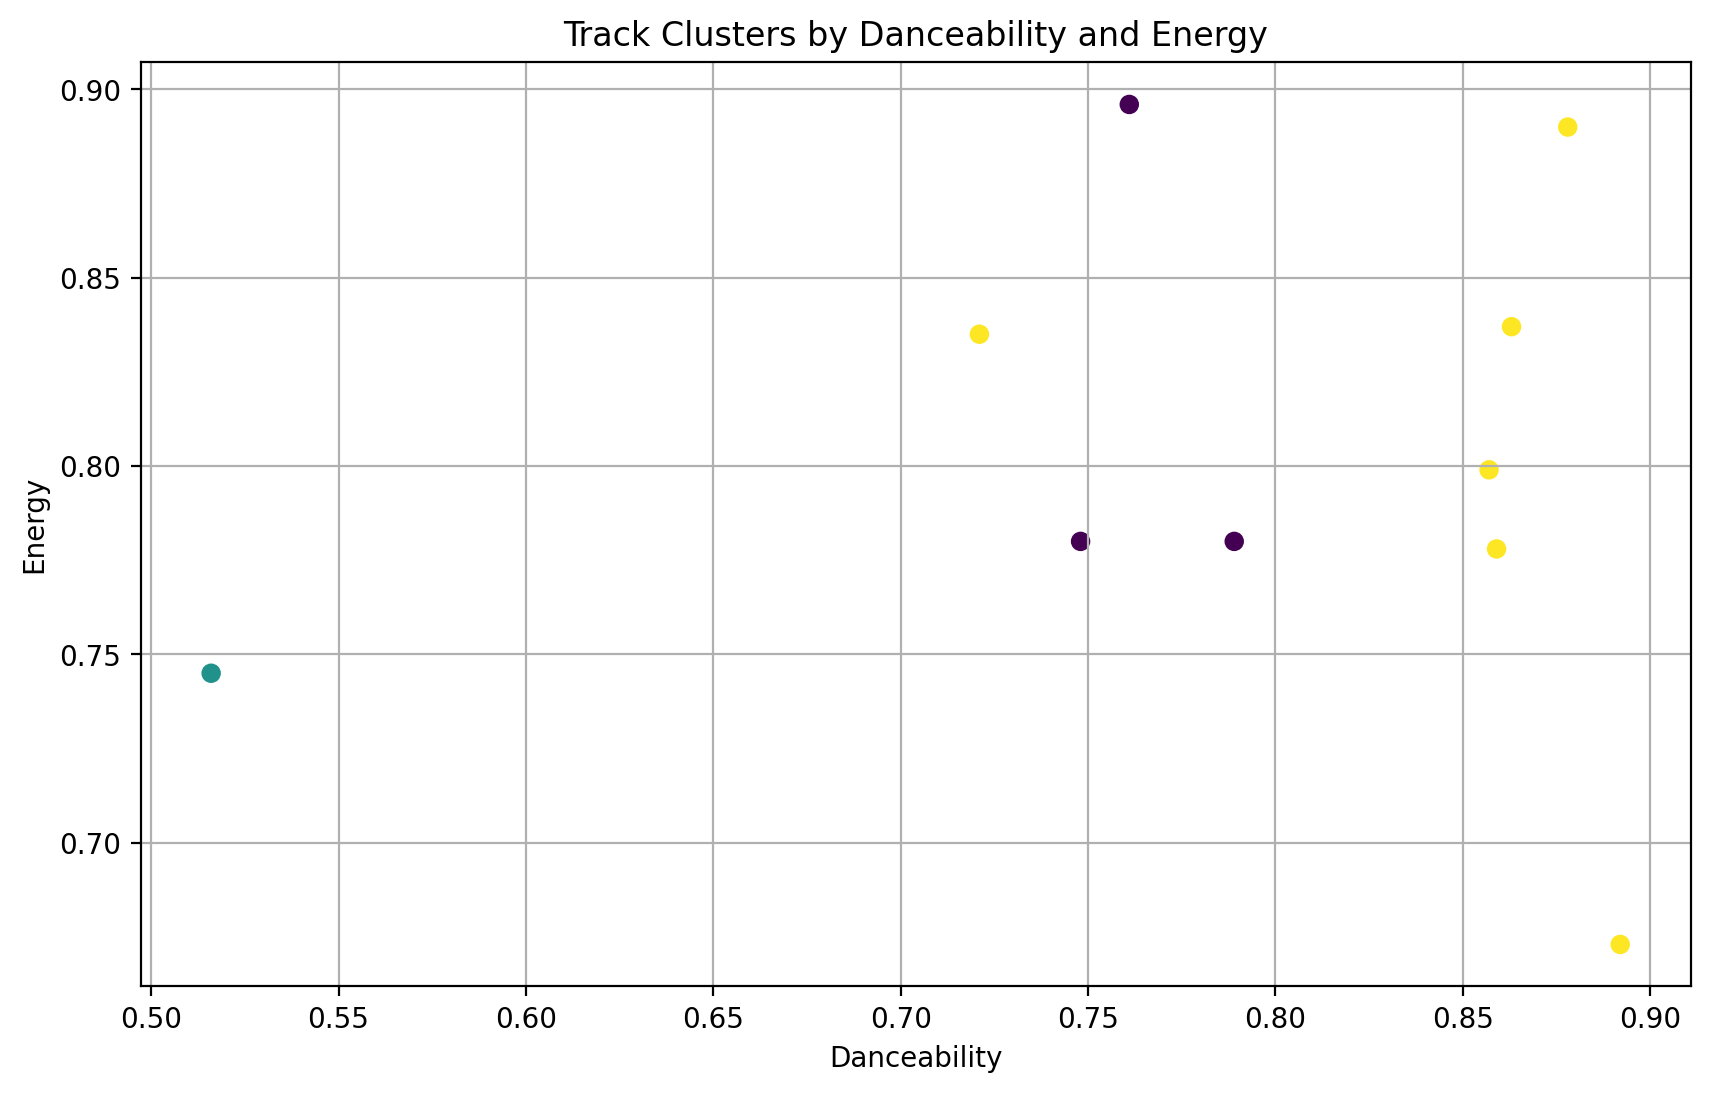

In [13]:
# Select relevant audio features for clustering
audio_features = df_artist_data[['Danceability', 'Energy', 'Tempo (BPM)', 'Valence']]
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(audio_features)

# Add clusters to DataFrame
df_artist_data['Cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(df_artist_data['Danceability'], df_artist_data['Energy'], c=df_artist_data['Cluster'], cmap='viridis')
plt.title('Track Clusters by Danceability and Energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.grid(True)
plt.show()


**Key Elements:**

**X-axis: Danceability**

* Danceability is a measure of how suitable a track is for dancing. It ranges from 0 (not suitable) to 1 (very suitable).

**Y-axis: Energy**

* Energy is a measure of how energetic and intense a track is. It also ranges from 0 (not energetic) to 1 (very energetic).

The plot uses color to group similar tracks together, forming clusters. This suggests that tracks with similar Danceability and Energy values tend to cluster together.

There are three main clusters visible:

* Purple Cluster: Tracks with moderate Danceability and Energy.
* Yellow Cluster: Tracks with high Danceability and Energy.
* Teal Cluster: Tracks with low Danceability and moderate Energy.

This visualization shows that most of Diamond platnumz tracks tend to have high danceability and energy.

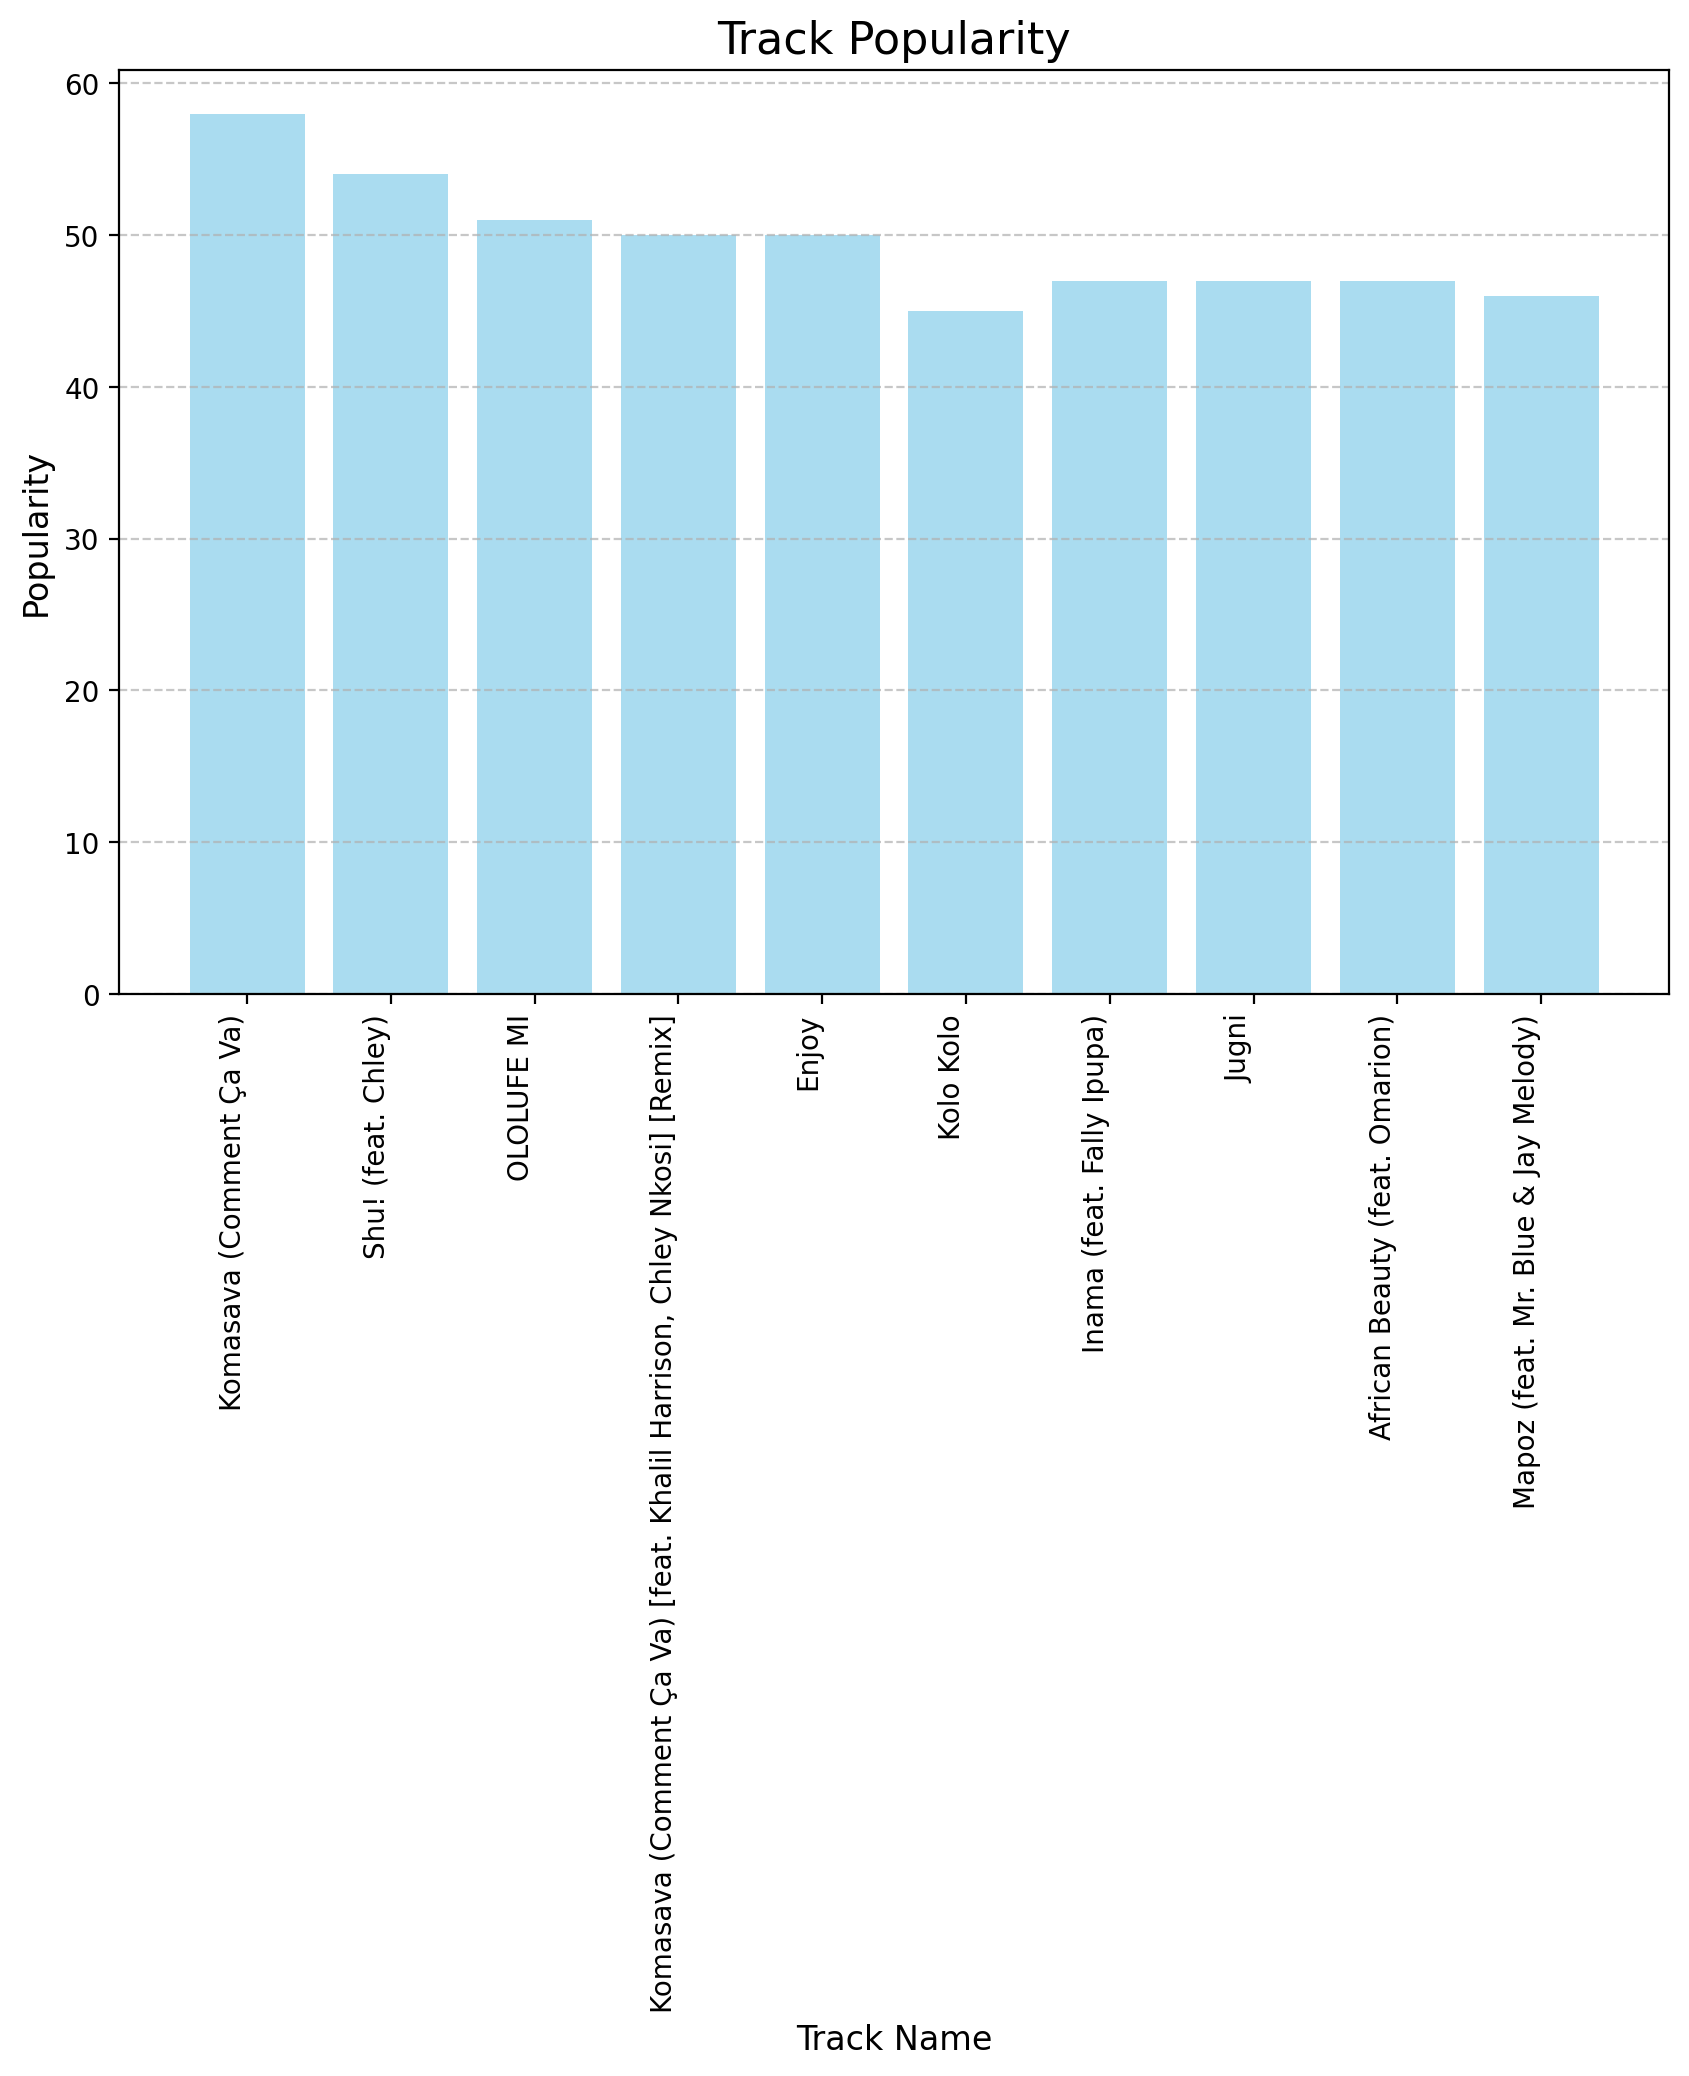

In [14]:
# Convert 'Popularity' to numeric (some tracks may have 'N/A' so we will handle that)
df_artist_data['Popularity'] = pd.to_numeric(df_artist_data['Popularity'], errors='coerce')

# Visualize the popularity of the tracks
plt.figure(figsize=(10, 6))
plt.bar(df_artist_data['Track Name'], df_artist_data['Popularity'], color='skyblue', alpha=0.7)
plt.xticks(rotation=90, ha='right')  # Rotate track names for better visibility
plt.title('Track Popularity', fontsize=16)
plt.xlabel('Track Name', fontsize=12)
plt.ylabel('Popularity', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

**Observations:**

* The x-axis shows the names of the tracks, and the y-axis represents the popularity score, which is measured on a scale from 0 to 60.

* The height of each bar corresponds to the popularity score of the respective track. The higher the bar, the more popular the track.

* Based on the chart, **"Komasava (Comment Ça Va)"** appears to be the most popular track, while **"Mapoz (feat. Mr. Blue & Jay Melody)"** seems to be the least popular among the tracks shown.

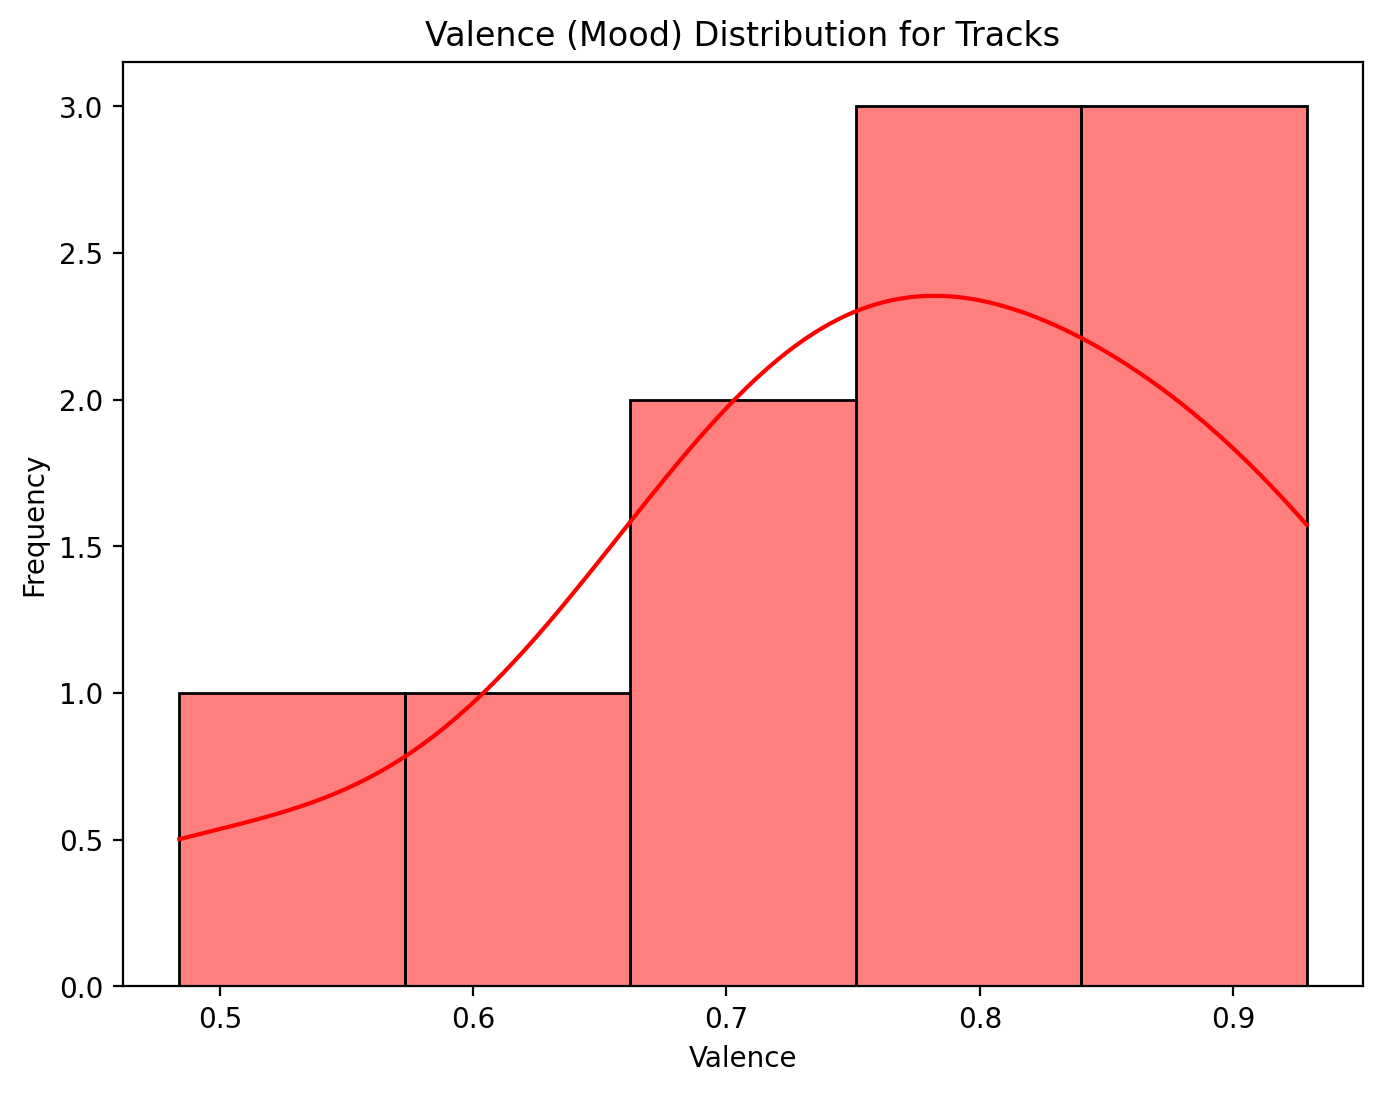

In [15]:
# Valence distribution (Mood analysis)
plt.figure(figsize=(8, 6))
sns.histplot(df_artist_data['Valence'], kde=True, color='red')
plt.title('Valence (Mood) Distribution for Tracks')
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.show()


This plot represents the **valence distribution for popular tracks by Diamond Platnumz**, where valence is a measure of the mood conveyed by the music (e.g., happiness or positivity). It combines a histogram (red bars) with a KDE (Kernel Density Estimate) curve (red line) for a smoother visualization of the distribution.

**Key Elements:**

* **X-Axis (Valence):** Represents the valence values, ranging from approximately 0.5 to 0.9.Lower valence indicates a more negative or sad mood, while higher valence corresponds to a more positive or happy mood.

* **Y-Axis (Frequency):** Represents the frequency of tracks within specific valence ranges.

* **Histogram:** The red bars show the frequency of tracks with specific valence values.Most tracks are concentrated between 0.6 and 0.8, suggesting a tendency toward neutral-to-positive moods.

**KDE Curve:**

* The red line smooths out the histogram to show the general trend in valence distribution.

* It peaks around 0.75, indicating that the majority of tracks have a valence value near this level.

**Observations:**

* The mood of most tracks is skewed toward higher valence values, meaning **the tracks are generally more positive or happy**.

* There are fewer tracks with very low or very high valence (below 0.6 or above 0.85).

* The curve suggests that the distribution is slightly right-skewed, with a peak in the mid-to-high range of valence values.





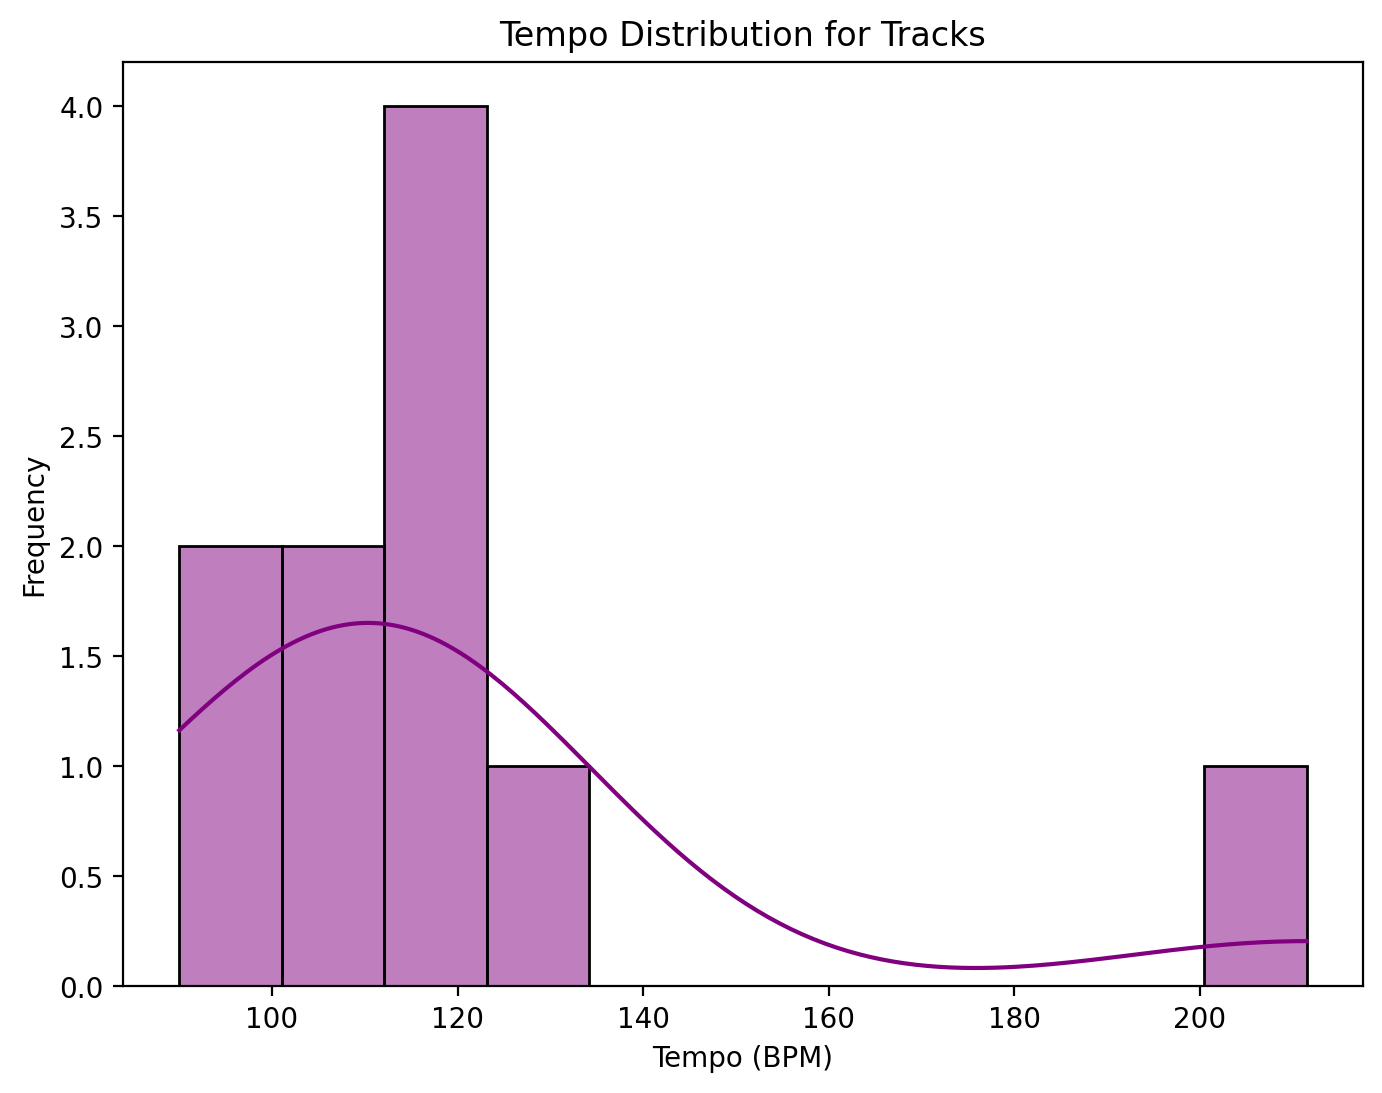

In [16]:
# Tempo distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_artist_data['Tempo (BPM)'], kde=True, color='purple')
plt.title('Tempo Distribution for Tracks')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.show()


**Interpretation:**

* This plot shows the tempo distribution for tracks in terms of Beats Per Minute (BPM). It combines a histogram (in purple bars) and a KDE (Kernel Density Estimate) line in dark purple to visualize the distribution pattern.

**Key Points:**

* **X-Axis (Tempo BPM):** Represents the tempo of tracks in beats per minute, ranging approximately from 80 to 220 BPM.

* **Y-Axis (Frequency):** Indicates the frequency or density of tracks at a particular tempo range.

* **Histogram:** The purple bars show the count of tracks grouped within specific tempo intervals. Most tracks fall within the 100–140 BPM range, with a peak around 120 BPM.

* **KDE Curve:** The dark purple line smooths out the histogram by showing the estimated probability density. It suggests the relative likelihood of different tempo values.

**Observations:**

The majority of tracks are concentrated around the 120 BPM mark.
There is a lower frequency of tracks in the higher tempo range (e.g., above 180 BPM).

The KDE curve confirms the peak near 120 BPM and a decline in density as tempos become either much slower or faster.

# **Album Analysis**

In [17]:
# Get artist's albums (limit to 50 albums per call, you can adjust)
results = sp.artist_albums(artist_uri, album_type='album', limit=50)

# Extract album details into a list
album_data = []
track_data = []  # To store track data for each album

for album in results['items']:
    album_name = album['name']
    album_uri = album['uri']
    album_release_date = album['release_date']

    # Fetch tracks from the album
    tracks = sp.album_tracks(album_uri)

    # Track statistics for each album
    total_tracks = len(tracks['items'])
    explicit_tracks = sum(1 for track in tracks['items'] if track['explicit'])
    track_lengths = [track['duration_ms'] for track in tracks['items']]
    avg_track_length = sum(track_lengths) / total_tracks if total_tracks > 0 else 0

    # Popularity for the album (average of track popularities)
    popularity_scores = [track.get('popularity', 0) for track in tracks['items']]
    avg_popularity = sum(popularity_scores) / len(popularity_scores) if popularity_scores else 0

    # Save album stats
    album_data.append({
        'Album Name': album_name,
        'Release Date': album_release_date,
        'Total Tracks': total_tracks,
        'Explicit Tracks': explicit_tracks,
        'Non-Explicit Tracks': total_tracks - explicit_tracks,
        'Average Track Length (ms)': avg_track_length,
        'Average Popularity': avg_popularity
    })

# Create a DataFrame from the album data
df_albums = pd.DataFrame(album_data)
# Convert 'Average Track Length (ms)' to minutes
df_albums['Average Track Length (min)'] = df_albums['Average Track Length (ms)'] / 60000
# view the head of the data
df_albums.head()

,Album Name,Release Date,Total Tracks,Explicit Tracks,Non-Explicit Tracks,Average Track Length (ms),Average Popularity,Average Track Length (min)
0,First Of All (Acoustic),2022-07-15,7,0,7,209766.571429,0.0,3.496110
1,First Of All,2022-03-11,10,0,10,201759.000000,0.0,3.362650
2,A Boy From Tandale,2018-02-16,18,1,17,226901.333333,0.0,3.781689
3,Lala Salama,2013-11-28,10,0,10,222021.500000,0.0,3.700358
4,Kamwambie,2013-11-28,12,0,12,251507.666667,0.0,4.191794


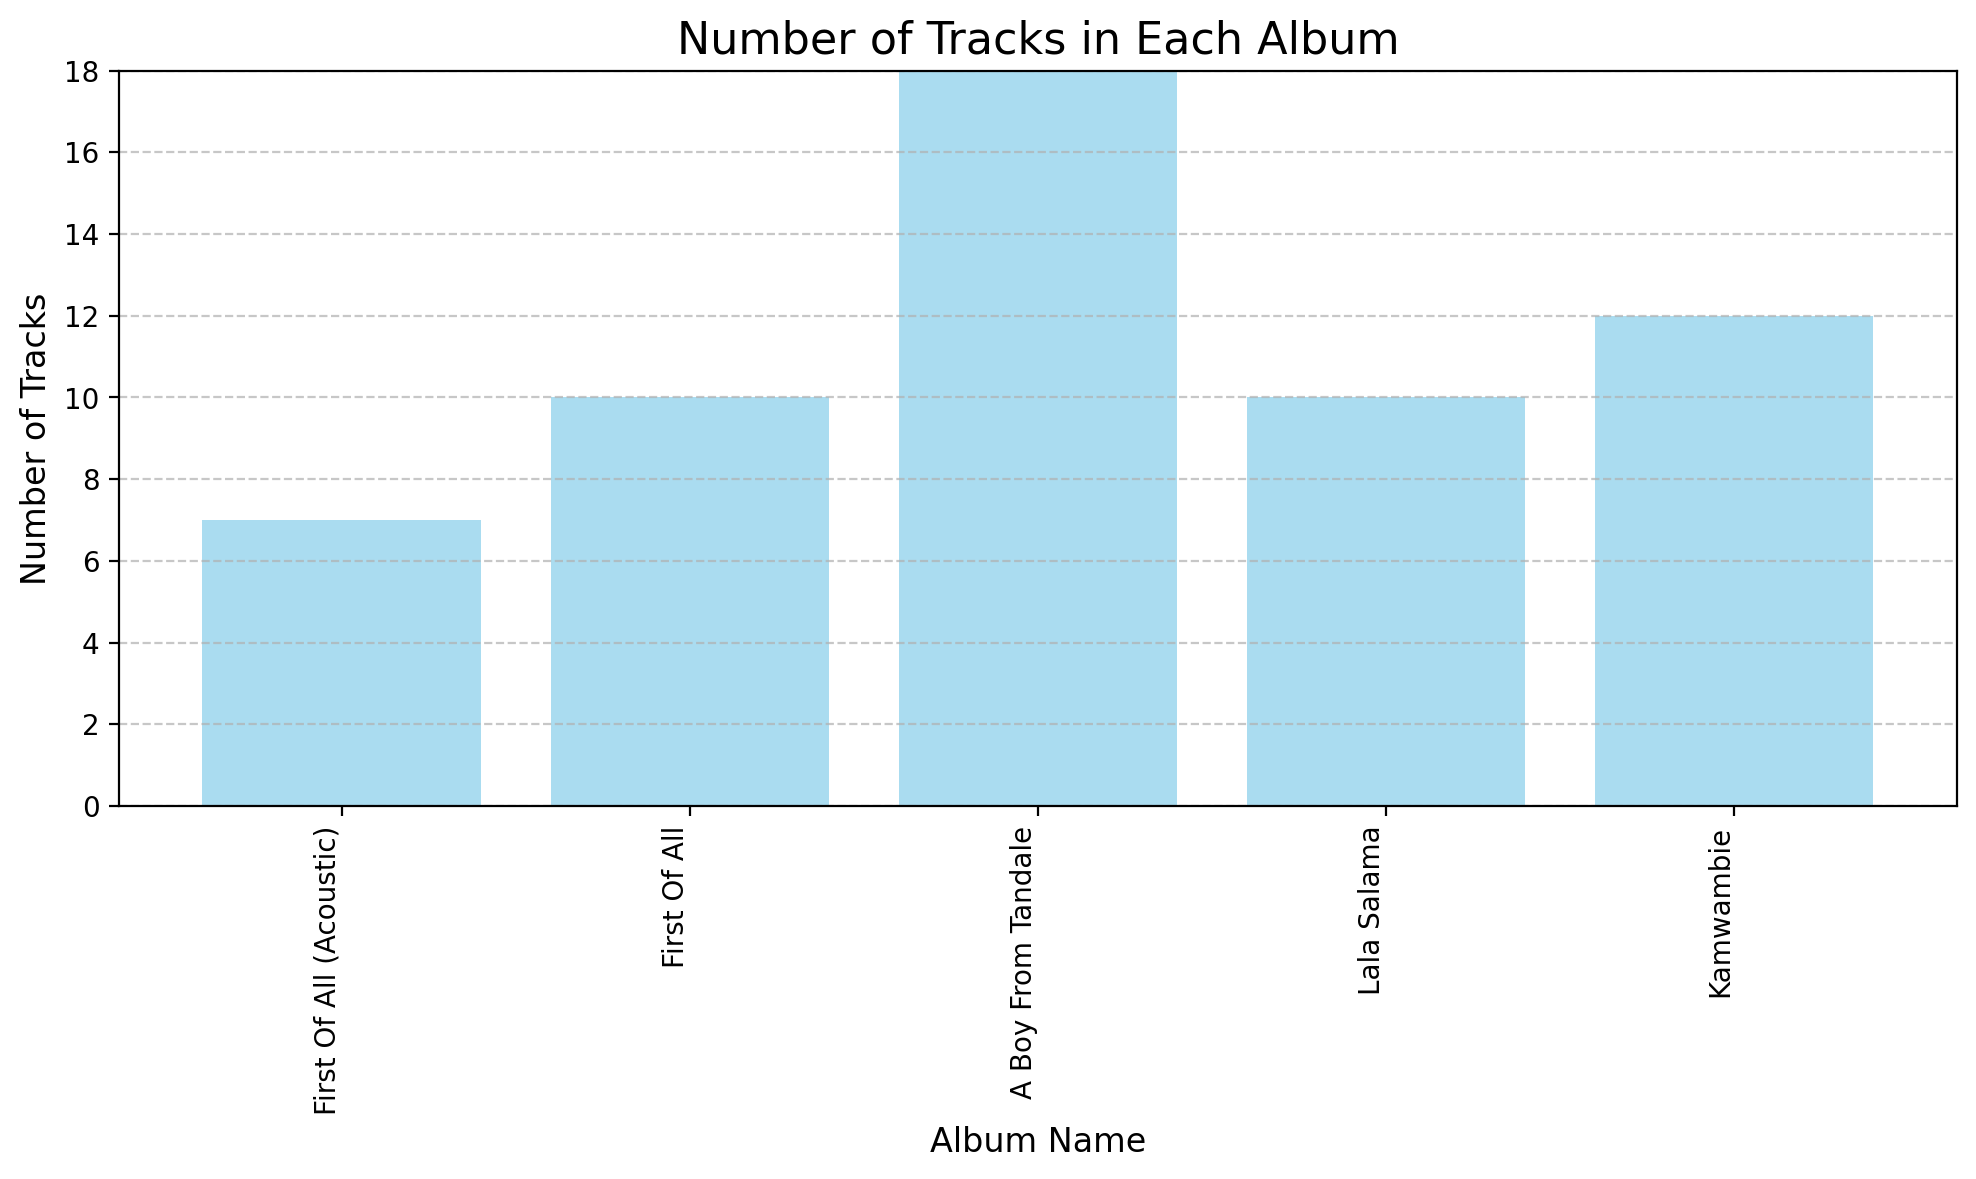

In [18]:
# Plot the number of tracks in each album
plt.figure(figsize=(10, 6))
plt.bar(df_albums['Album Name'], df_albums['Total Tracks'], color='skyblue', alpha=0.7)
plt.xticks(rotation=90, ha='right')
plt.title('Number of Tracks in Each Album', fontsize=16)
plt.xlabel('Album Name', fontsize=12)
plt.ylabel('Number of Tracks', fontsize=12)
plt.ylim(0, 18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Overview**

This bar chart visualizes the number of tracks in each of Diamond Platnumz's albums. It provides insights into the album lengths and content diversity.

**Key Observations**

* **Varied Track Counts:** The chart shows that Diamond Platnumz's albums have varying numbers of tracks.

* **"A Boy From Tandale" as the Longest Album:** This album stands out with the highest number of tracks, indicating a diverse range of songs.

* **Consistent Track Count:** The remaining albums have a more consistent number of tracks, suggesting a balanced approach to album length.

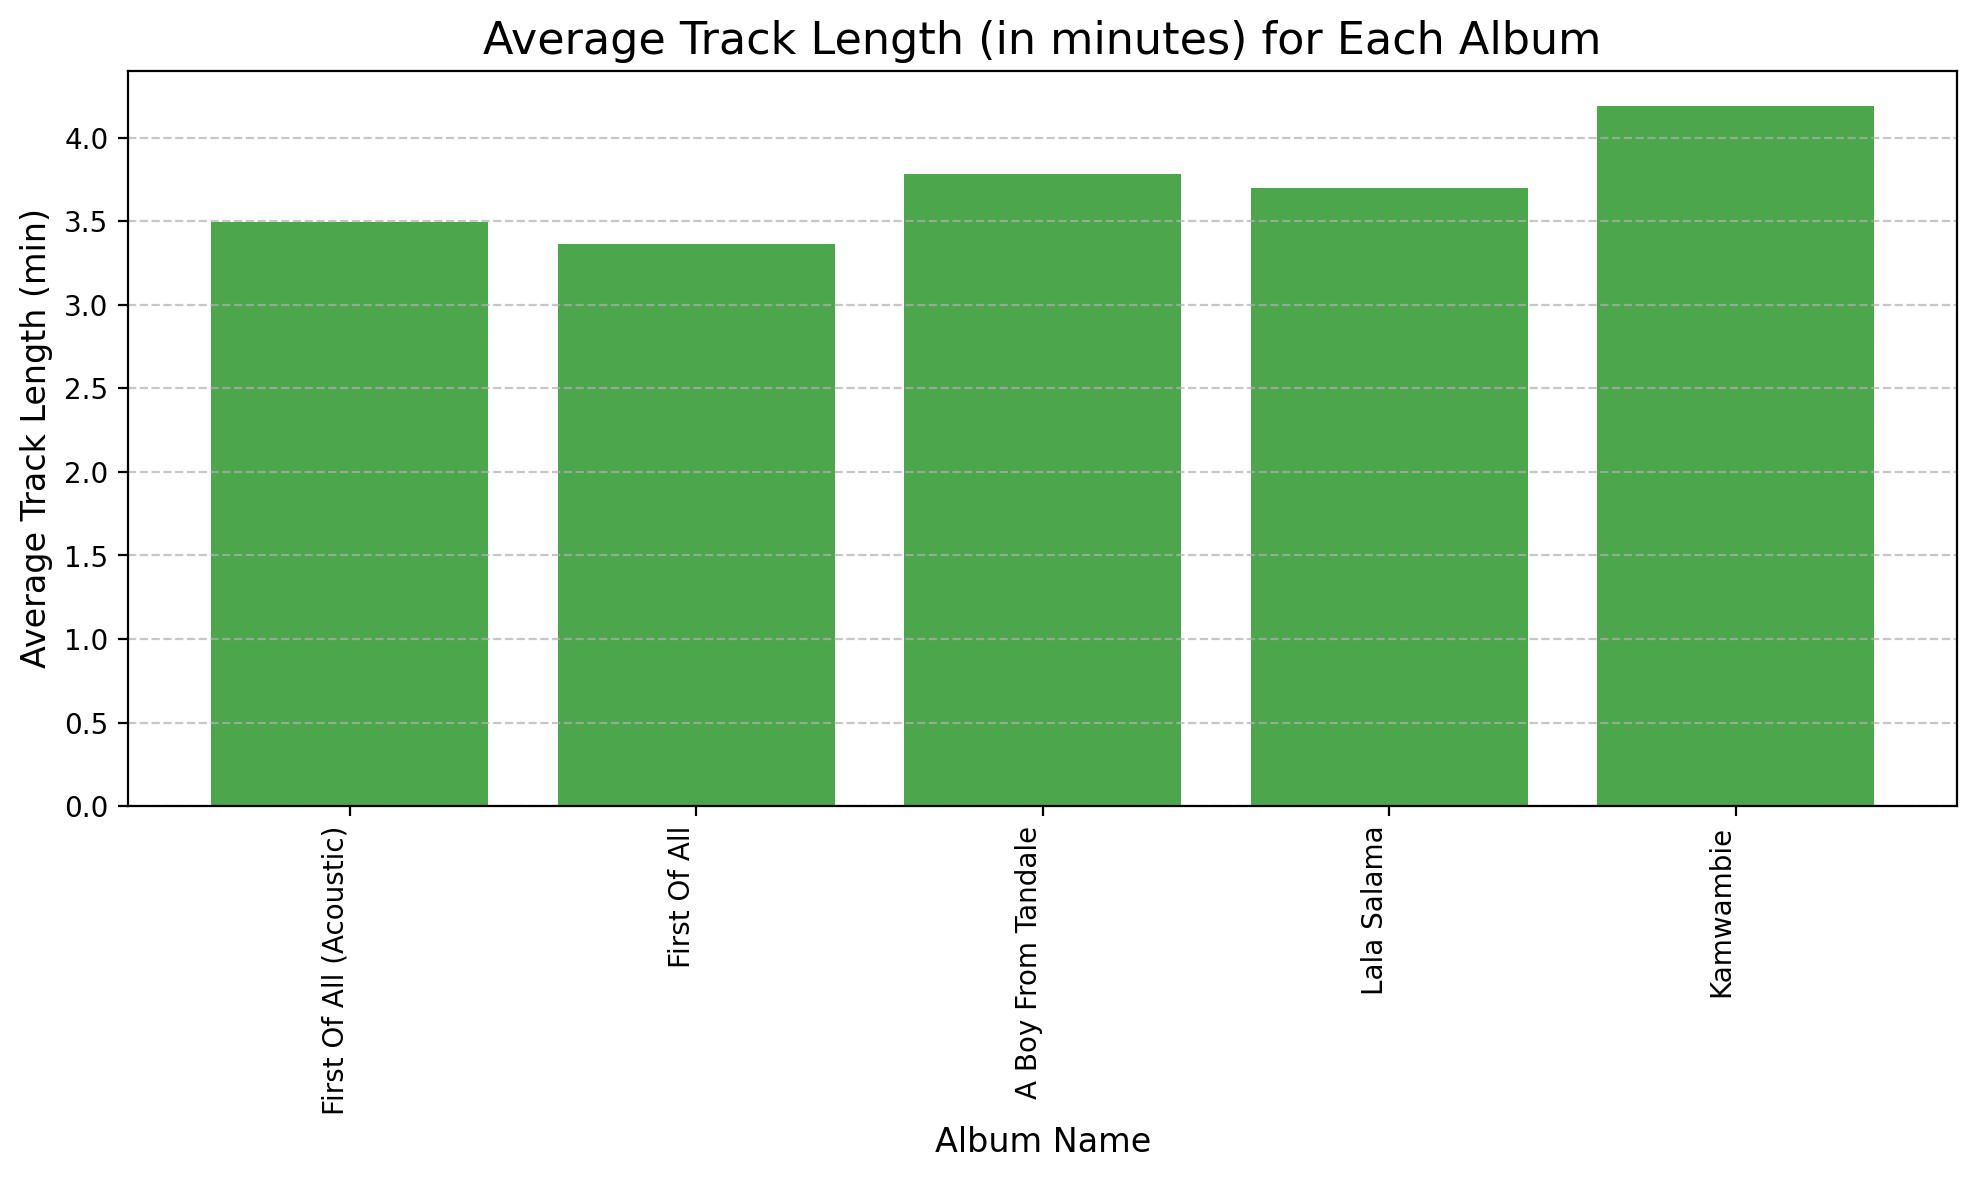

In [19]:
# Plot the average track length in minutes for each album
plt.figure(figsize=(10, 6))
plt.bar(df_albums['Album Name'], df_albums['Average Track Length (min)'], color='green', alpha=0.7)
plt.xticks(rotation=90, ha='right')
plt.title('Average Track Length (in minutes) for Each Album', fontsize=16)
plt.xlabel('Album Name', fontsize=12)
plt.ylabel('Average Track Length (min)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Overview**

This bar chart visualizes the average track length in minutes for each of Diamond Platnumz's albums. It provides insights into the pacing and overall listening experience of each album.

**Key Observations**

* **Varied Average Track Length:** The chart shows that Diamond Platnumz's albums have varying average track lengths.

* **"Kamwambie" as the Longest:** This album stands out with the longest average track length, indicating that the songs on this album tend to be longer in duration.

* **Consistent Range:** The other albums have a more consistent range of average track lengths, suggesting a balanced approach to pacing.

<Figure size 1000x1000 with 0 Axes>

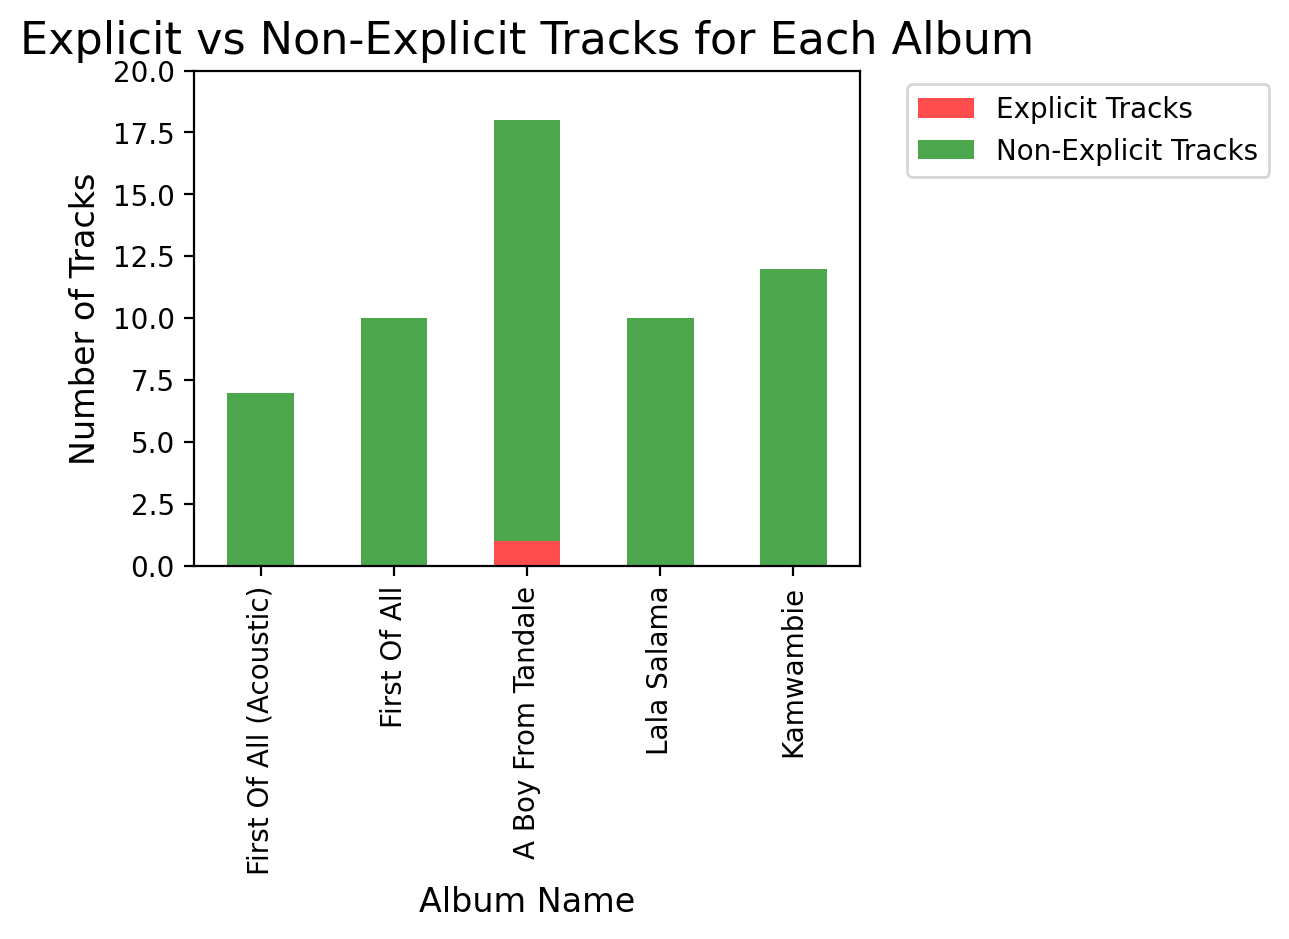

In [20]:
# Plot the explicit and non-explicit track count for each album
plt.figure(figsize=(10, 10))
df_albums[['Explicit Tracks', 'Non-Explicit Tracks']].plot(kind='bar', stacked=True, color=['red', 'green'], alpha=0.7)
plt.xticks(range(len(df_albums)), df_albums['Album Name'], rotation=90)
plt.title('Explicit vs Non-Explicit Tracks for Each Album', fontsize=16)
plt.xlabel('Album Name', fontsize=12)
plt.ylabel('Number of Tracks', fontsize=12)
plt.ylim(0,20)
# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Overview**

This grouped bar chart visualizes the number of explicit and non-explicit tracks in each of Diamond Platnumz's albums. It provides insights into the content of his albums and the artist's approach to explicit lyrics.

**Key Observations**

**Dominance of Non-Explicit Tracks:** The majority of tracks in each album are non-explicit, indicating that Diamond Platnumz may primarily focus on creating music suitable for a wide audience.

**"A Boy From Tandale" as an Exception:** This album stands out with a few  number of explicit tracks, suggesting a more mature and explicit theme compared to other albums.

**Consistent Pattern:** The other albums follow a consistent pattern of predominantly non-explicit content.